In [319]:
from kaggle_environments import make
from kaggle_environments.envs.halite.helpers import *

# Create a test environment for use later
board_size = 9
environment = make("halite", configuration={"size": board_size, "startingHalite": 1000})
agent_count = 1

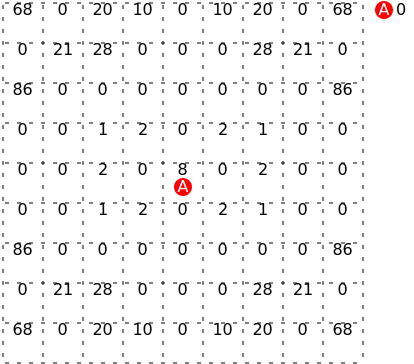

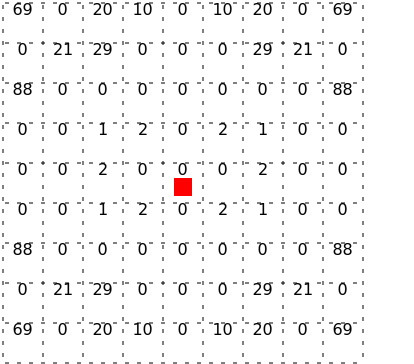

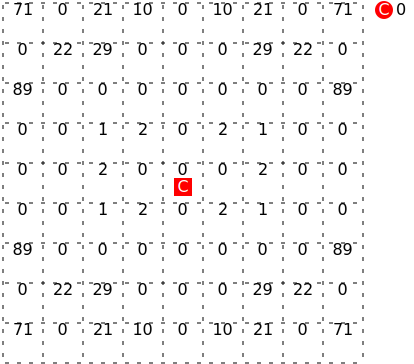

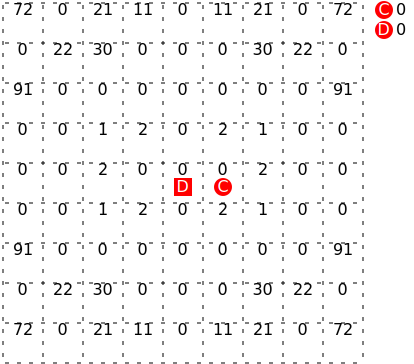

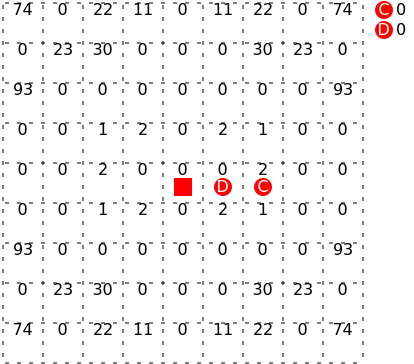

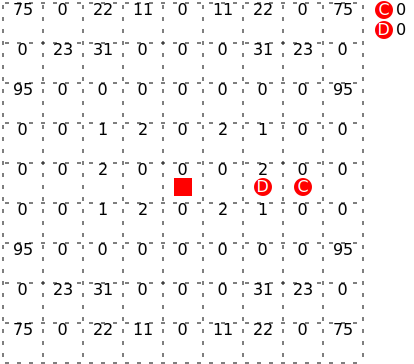

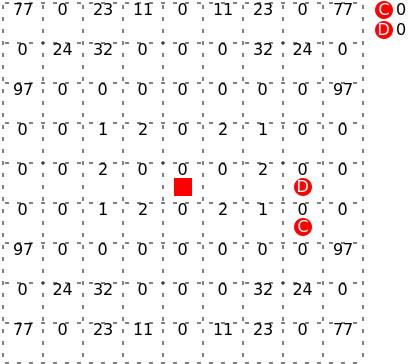

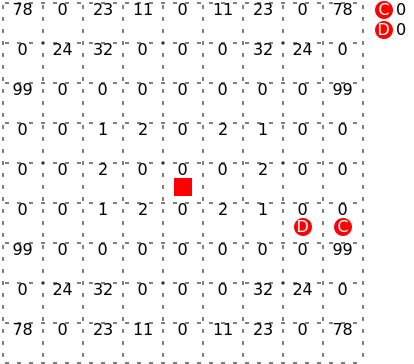

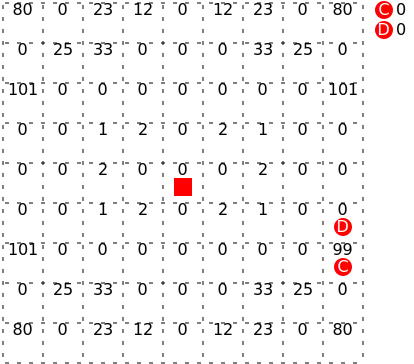

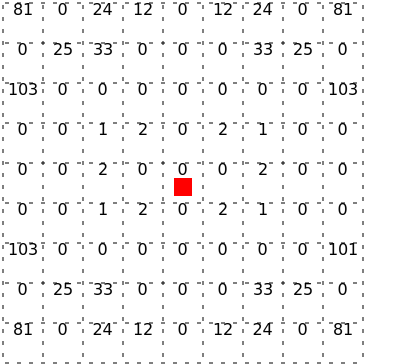

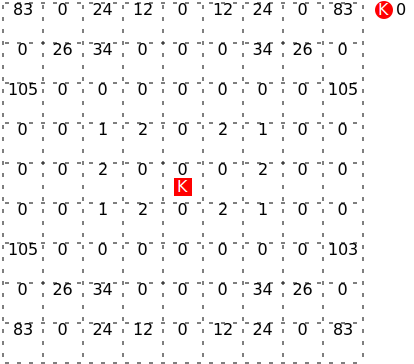

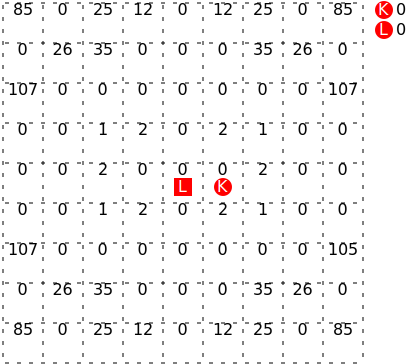

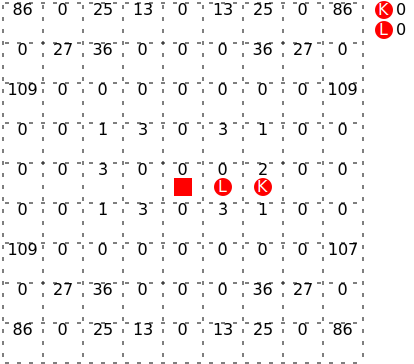

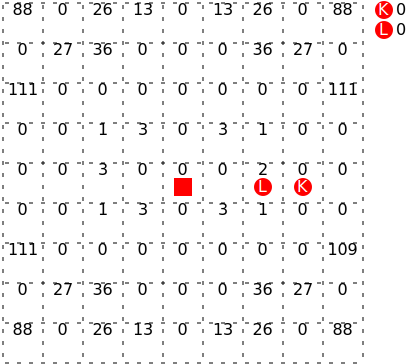

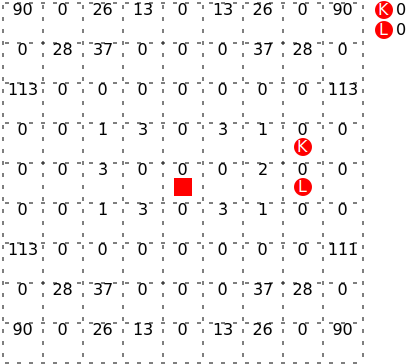

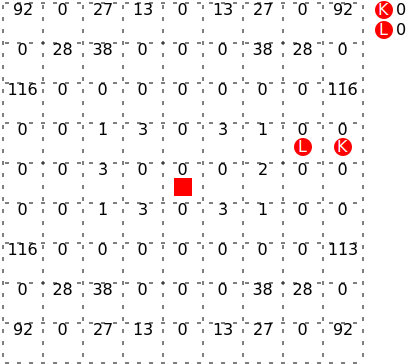

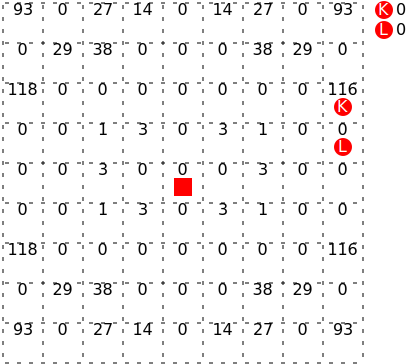

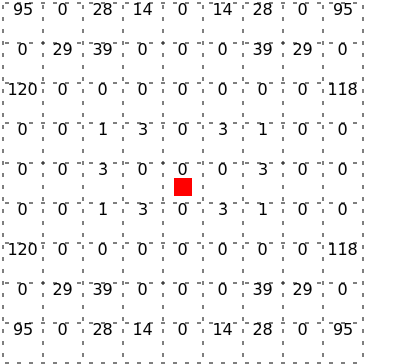

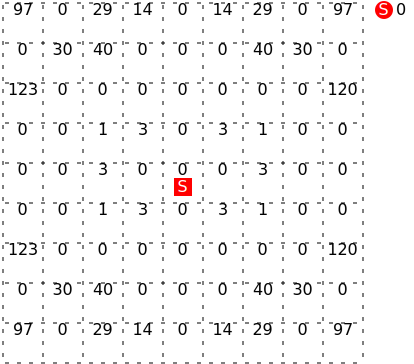

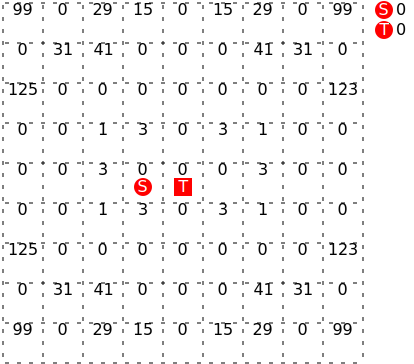

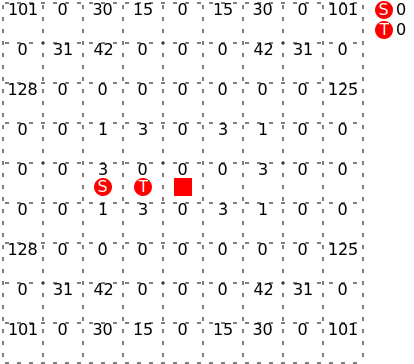

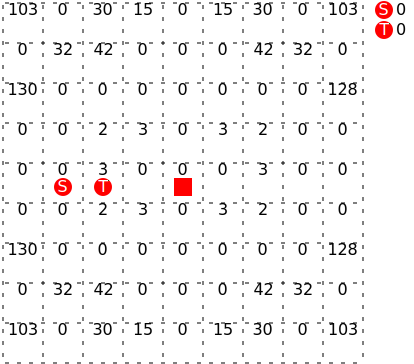

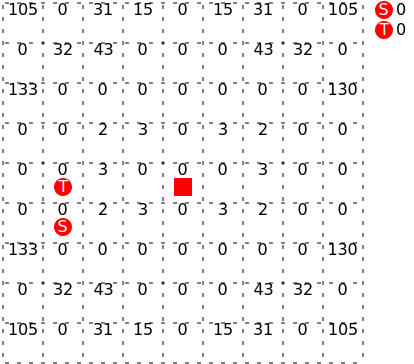

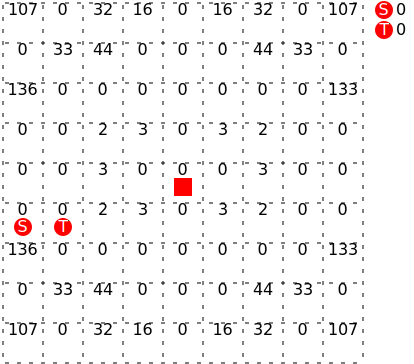

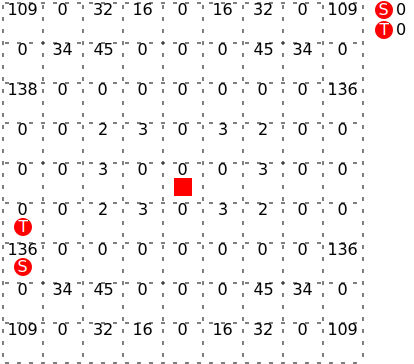

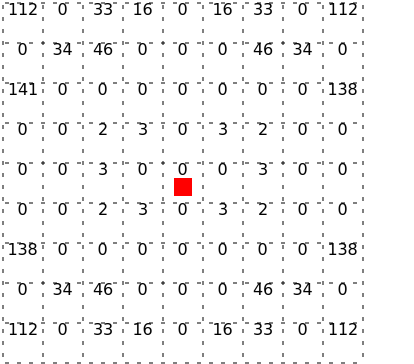

IndexError: string index out of range

In [349]:
import random

def vector_distance(origin: Point, dest: Point):
    center = Point(board_size // 2, board_size // 2)
    return (dest - origin + center) % board_size - center

def manhattan_distance(p1: Point, p2: Point):
    dp = abs(vector_distance(p1, p2))
    return dp.x + dp.y

def magnitude(p):
    return abs(p.x) + abs(p.y)

def safe_float_div(p: Point, scalar):
    ''' floating point divide by a scalar number, returns zeros instead raising an exception'''
    return Point(p.x/scalar if p.x != 0 else 0, p.y/scalar if p.y != 0 else 0)

def direction(origin, destination):
    ''' Returns a unit vector in the direction from origin to destination'''
    return safe_float_div(vector_distance(origin, destination), manhattan_distance(origin, destination))

def halite_move_force(ship, cell):
    ''' calculates the pull force vector of halite on the ship'''
    dist = manhattan_distance(ship.position, cell.position)
    # divide halite by distance to get initial magnitude
    magnitude = cell.halite / dist if dist > 0 else 0
    return direction(ship.position, cell.position) * magnitude

stay_power = 1.4
cluster_power = 0.1

def force_to_action(best_move_force, sum_move_force, stay_force):
    ''' Turns three input values into a Ship action
    best_move_force is the best calculated single cell to move to
    sum_move_force is the best overall direction to move toward
    stay_force is the magnitude of how good our current cell is
    we use stay_power and cluster_power to scale them
    '''
    move_force = best_move_force + sum_move_force * cluster_power
    stay_force = stay_force * stay_power
    if stay_force > abs(move_force.x) and stay_force > abs(move_force.y):
        return None
    if abs(move_force.x) > abs(move_force.y):
        if move_force.x > 0:
            return ShipAction.EAST
        return ShipAction.WEST
    if move_force.y > 0:
        return ShipAction.NORTH
    return ShipAction.SOUTH

def next_move(board, ship, t):
    if t == 0:
        return ShipAction.CONVERT
    sum_move_force = Point(0, 0)
    best_move_force = Point(0, 0)
    for cpos, cell in board.cells.items():
        move_force = halite_move_force(ship, cell)
        best_move_force = max(move_force, best_move_force, key=magnitude)
        sum_move_force += move_force
    return force_to_action(best_move_force, sum_move_force, board.cells[ship.position].halite)

environment.reset(agent_count)
state = environment.state[0]
board = Board(state.observation, environment.configuration)
t = 0
def step(board, t):
    for ship in board.ships.values():
        ship.next_action = next_move(board, ship, t)
    for shipyard in board.shipyards.values():
        if len(board.ships) < 2:
            shipyard.next_action = ShipyardAction.SPAWN

display(draw_board(board))
boards = [board]
for i in range(50):
    step(board, t)
    t += 1
    board = board.next()
    boards.append(board)
    display(draw_board(board))
    if len(board.ships)+ len(board.shipyards)==0:
        break

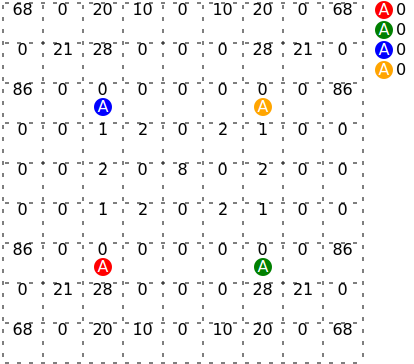

In [347]:
import xml.etree.ElementTree as ET
from IPython.display import SVG, display
from dataclasses import dataclass

@dataclass
class Dimension:
    width: int
    height: int
    
    def __mul__(self, other):
        return Dimension(self.width * other.width, self.height * other.height)
    
    def __add__(self, other):
        return Dimension(self.width + other.width, self.height + other.height)

@dataclass(frozen=True)
class DPoint:
    x: int
    y: int
        
    def __repr__(self):
        return f'({self.x}, {self.y})'
    
    def scale(self, mult: Dimension, plus=Dimension(0, 0)):
        return Point(
            self.x * mult.width + plus.width,
            self.y * mult.height + plus.height
        )

board_dim = Dimension(board_size, board_size)
margin_dim = Dimension(3, 3)
node_dim = Dimension(40, 40)
stroke_size = Dimension(1, 1)
side_bar = Dimension(50, 0)
side_bar_row_height = Dimension(1, 20)
tiles_dim = board_dim * node_dim + margin_dim + stroke_size
svg_dims =  tiles_dim + side_bar

colors = ['red', 'green', 'blue', 'orange']
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ!@#$%^&*'
def draw_board(board, cell_halite_enable):
    svg = ET.Element(
        'svg',
        xmlns="http://www.w3.org/2000/svg",
        version="1.1",
        height=str(svg_dims.height),
        width=str(svg_dims.width))
    svg.append(ET.fromstring('''
        <style>
            line { stroke: black }
        </style>'''))
    
    # draw dashed gray grid
    for x in range(board_dim.width + 1):
        p = DPoint(x, 0).scale(node_dim, margin_dim)
        svg.append(ET.fromstring(f'<line x1="{p.x}" x2="{p.x}" y1="5" y2="{tiles_dim.height}" stroke-dasharray="4 8"/>'))
    for y in range(board_dim.height + 1):
        p = DPoint(0, y).scale(node_dim, margin_dim)
        svg.append(ET.fromstring(f'<line x1="5" x2="{tiles_dim.width}" y1="{p.y}" y2="{p.y}" stroke-dasharray="4 8"/>'))
    
    
    # draw cell halite
    for cell in board.cells.values():
        p = DPoint(cell.position.x, cell.position.y).scale(node_dim, margin_dim + node_dim * Dimension(0.5, 0.3))
        svg.append(ET.fromstring(f'<text x="{p.x}" y="{p.y}" text-anchor="middle">{cell.halite:.0f}</text>'))
    
    # shipyards
    for shipyard in board.shipyards.values():
        p = DPoint(shipyard.position.x, shipyard.position.y).scale(node_dim, margin_dim+Dimension(11,15))
        svg.append(ET.fromstring(f'<rect x="{p.x}" y="{p.y}" width="18" height="18" fill="{colors[shipyard.player_id]}" />'))
    
    # draw ship positions
    for i, ship in enumerate(board.ships.values()):
        sid = letters[int(ship.id.split('-')[0])]
        p = DPoint(ship.position.x, ship.position.y).scale(node_dim, margin_dim + node_dim * Dimension(0.5, 0.6))
        svg.append(ET.fromstring(f'<circle cx="{p.x}" cy="{p.y}" r="9" fill="{colors[ship.player_id]}" />'))
        svg.append(ET.fromstring(f'<text x="{p.x}" y="{p.y+5}" text-anchor="middle" fill="white">{sid}</text>'))
        p = DPoint(20, i).scale(side_bar_row_height, Dimension(tiles_dim.width, 10))
        svg.append(ET.fromstring(f'<circle cx="{p.x}" cy="{p.y}" r="9" fill="{colors[ship.player_id]}" />'))
        svg.append(ET.fromstring(f'<text x="{p.x}" y="{p.y+5}" text-anchor="middle" fill="white">{sid}</text>'))
        svg.append(ET.fromstring(f'<text x="{p.x+12}" y="{p.y+5}" >{ship.halite}</text>'))
    
    for player in board.players.values():
        
        
        
    return SVG(ET.tostring(svg))

environment = make("halite", configuration={"size": board_size, "startingHalite": 1000})
environment.reset(4)
state = environment.state[0]
board = Board(state.observation, environment.configuration)
draw_board(board)

In [315]:
from ipywidgets import interact
import ipywidgets as widgets

In [351]:

def display_boards(t, cell_halite_enable):
    return draw_board(boards[t], cell_halite_enable)
_ = interact(display_boards, t=widgets.IntSlider(min=0, max=len(boards)-2, step=1, value=0), cell_halite_enable=True)

interactive(children=(IntSlider(value=0, description='t', max=25), Checkbox(value=True, description='cell_hali…